In [1]:
import psycopg2
from sqlalchemy import create_engine
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import log_loss, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
% matplotlib inline

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from data_cleaning.create_staging_tables import create_staging_legislator_df_STEP_ONE, create_staging_bill_df_STEP_THREE

#### features to create:
* rep_score DONE
* minority_score
* num_sponsors DONE
* date_introduced
* type_dummies
* bill_length


#### features to clean:
* sponsor_agency DONE

In [2]:
engine = create_engine('postgresql://localhost:5432/wa_leg_raw')

In [3]:
raw_bill_df = pd.read_sql_query('select * from "bill_api"', con=engine)
raw_sponsor_df = pd.read_sql_query('select * from "sponsor_api"', con=engine)
raw_vote_df = pd.read_sql_query('select * from "vote_api"', con=engine)
raw_committee_member_df = pd.read_sql_query('select * from "committee_member_api"', con=engine)
missing_leg_info_df = pd.read_csv('../data/missing_legislators.csv', sep = '|')
raw_sponsor_df = pd.read_sql_query('select * from "sponsor_api"', con=engine)

In [4]:
legislator_df = create_staging_legislator_df_STEP_ONE(raw_vote_df, raw_committee_member_df, missing_leg_info_df)

In [6]:
def change_party_word_to_int(party):
        if party == 'Democrat':
            return 0
        if party == 'Republican':
            return 1

In [7]:
legislator_df['party'] = legislator_df['party'].apply(change_party_word_to_int)

In [8]:
bill_df = create_staging_bill_df_STEP_THREE(raw_bill_df, raw_sponsor_df)

/Users/emilykarboski/galvanize/washington_state_legislation/data_cleaning/create_staging_tables.py:372: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sponsor_df_reformatted['bill_num'] = sponsor_df_reformatted['bill_id'].apply(lambda x: x.split()[1])
/Users/emilykarboski/galvanize/washington_state_legislation/data_cleaning/create_staging_tables.py:373: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sponsor_df_reformatted['bill_num_unique'] = sponsor_df_reformatted['biennium'] + ' ' + sponsor_df_reformatted['bill_num']


In [9]:
minority_df = pd.read_csv('../data/party_minority_history.csv', sep='|')

In [17]:
def create_final_bill_df(staging_bill_df, raw_vote_df):
    """Creates a dataframe with all bills and bill info including a column labeling whether the bill has
    been voted on or not. This dataframe will be used to model whether a bill will make it to a vote."""
    
    raw_vote_df['bill_unique'] = raw_vote_df['biennium'] + ' ' + raw_vote_df['bill_id']
    bills_already_voted_on = raw_vote_df['bill_unique'].unique()
    
    def determine_if_reached_vote(bill_unique):
        if bill_unique in bills_already_voted_on:
            return True
        return False
    
    def filter_out_old_versions(row):
        count = len(staging_bill_df[staging_bill_df['bill_num_unique'] == row['bill_num_unique']])
        if count > 1 and row['reached_vote'] == False:
            return False
        return True
    
    def count_sponsors(secondary_sponsors):
        """Counts secondary sponsors, adding one for the primary sponsors"""
        if type(secondary_sponsors) == list:
            return len(secondary_sponsors) + 1
        else: return 1
        
    def change_agency_to_int(agency):
        if agency == 'House':
            return 0
        if agency == 'Senate':
            return 1
        
    def create_bill_rep_score(row):
        '''Return # of republican sponsors / total sponsors. If there are no secondary sponsors return -1 so that
        later, when this table is joined with merged_final, the primary sponsor party can fill this field.'''
        sponsors = row['secondary_sponsors']
        if type(sponsors) == list:
            sponsors.append(row['primary_sponsor_id'])

            sponsor_parties = []
            for s in sponsors:
                subset_leg = legislator_df[legislator_df['id'] == int(s)]
                if len(subset_leg) > 0:
                    sponsor_party = sum(subset_leg.iloc[:, 4]) / len(subset_leg)
                    sponsor_parties.append(sponsor_party)
            bill_rep_score = np.mean(sponsor_parties)
            return bill_rep_score
        else:
            subset_leg = legislator_df[legislator_df['id'] == int(row['primary_sponsor_id'])]
            if len(subset_leg) > 0:
                primary_sponsor_party = sum(subset_leg.iloc[:, 4]) / len(subset_leg)
            else: primary_sponsor_party = 0.5
            return primary_sponsor_party
    
    def change_rep_score_to_minority_score(row):
        if row['sponsor_agency'] == 0:
            subset = minority_df[(minority_df['biennium'] == row['biennium']) & (minority_df['agency'] == 'House')]  
        if row['sponsor_agency'] == 1:
            subset = minority_df[(minority_df['biennium'] == row['biennium']) & (minority_df['agency'] == 'Senate')]
        subset = subset.reset_index()
        minority_party = subset.loc[0, 'minority_party']
        if minority_party == 'D':
            return 1 - row['rep_score']
        if minority_party == 'Even':
            return 0
        return row['rep_score']
    
    def change_biennium_to_year_count(biennium):
        year = int(biennium[0:4])
        return year - 1991
    
    staging_bill_df['reached_vote'] = staging_bill_df['bill_unique'].apply(determine_if_reached_vote)
    staging_bill_df['is_final_version'] = staging_bill_df.apply(filter_out_old_versions, axis=1)
    bill_df = staging_bill_df[staging_bill_df['is_final_version'] == True]
    bill_df = bill_df.drop(['is_final_version', 'description', 'long_friendly_name', 'name', 
                            'htm_last_modified_date'], axis=1)
    bill_df['sponsor_agency'] = bill_df['sponsor_agency'].apply(change_agency_to_int)
    bill_df['num_sponsors'] = bill_df['secondary_sponsors'].apply(count_sponsors)
    bill_df['rep_score'] = bill_df.apply(create_bill_rep_score, axis=1)
    bill_df['minority_score'] = bill_df.apply(change_rep_score_to_minority_score, axis=1)
    bill_df['year_count'] = bill_df['biennium'].apply(change_biennium_to_year_count)
    
    return bill_df

In [18]:
bill_df = create_final_bill_df(bill_df, raw_vote_df)

In [19]:
bill_df.head()

,biennium,bill_id,class,htm_create_date,htm_url,type,bill_unique,bill_num,bill_num_unique,sponsor_agency,primary_sponsor_id,secondary_sponsors,reached_vote,num_sponsors,rep_score,minority_score,year_count
1,1991-92,SHB 1001,Bills,1991-02-01T00:00:00,http://app.leg.wa.gov/documents/billdocs/1991-...,House Bills,1991-92 SHB 1001,1001,1991-92 1001,0,251,"[17, 429, 406, 72, 48, 474, 75, 481, 325, 34, ...",True,36,0.722222,0.722222,0
2,1991-92,HB 1002,Bills,1991-01-14T00:00:00,http://app.leg.wa.gov/documents/billdocs/1991-...,House Bills,1991-92 HB 1002,1002,1991-92 1002,0,251,"[207, 180, 110, 475, 219, 320, 332, 394, 227, ...",False,20,0.350000,0.350000,0
4,1991-92,SHB 1003,Bills,1991-02-21T00:00:00,http://app.leg.wa.gov/documents/billdocs/1991-...,House Bills,1991-92 SHB 1003,1003,1991-92 1003,0,311,"[110, 474, 54, 311, 311, 311]",True,6,0.166667,0.166667,0
5,1991-92,HB 1004,Bills,1991-01-14T00:00:00,http://app.leg.wa.gov/documents/billdocs/1991-...,House Bills,1991-92 HB 1004,1004,1991-92 1004,0,311,"[110, 475, 54, 304, 32, 311, 311, 311]",False,8,0.500000,0.500000,0
6,1991-92,HB 1005,Bills,1991-01-14T00:00:00,http://app.leg.wa.gov/documents/billdocs/1991-...,House Bills,1991-92 HB 1005,1005,1991-92 1005,0,311,"[475, 23, 311, 311, 311]",False,5,0.200000,0.200000,0


In [20]:
type_dummies = pd.get_dummies(bill_df['type'])

In [21]:
bill_df_with_dummies = pd.concat([bill_df, type_dummies], axis=1)

In [22]:
train = bill_df_with_dummies[bill_df_with_dummies['year_count'] <= 20]
test = bill_df_with_dummies[bill_df_with_dummies['year_count'] > 20]

In [23]:
# X_train = train[['sponsor_agency', 'primary_sponsor_id', 'num_sponsors', 'rep_score', 'bill_num', 'year_count']]
# X_test = test[['sponsor_agency', 'primary_sponsor_id', 'num_sponsors', 'rep_score', 'bill_num', 'year_count']]
X_train = train.drop(['year_count', 'primary_sponsor_id', 'sponsor_agency', 'biennium', 'bill_id', 'class', 'htm_create_date', 'htm_url', 'type', 'bill_unique', 'bill_num_unique',
                     'secondary_sponsors', 'reached_vote'], axis=1)
X_test = test.drop(['year_count', 'primary_sponsor_id', 'sponsor_agency', 'biennium', 'bill_id', 'class', 'htm_create_date', 'htm_url', 'type', 'bill_unique', 'bill_num_unique',
                     'secondary_sponsors', 'reached_vote'], axis=1)
y_train = train['reached_vote']
y_test = test['reached_vote']

In [56]:
baseline_model = GradientBoostingClassifier(learning_rate=0.05, n_estimators=700, max_depth=4, random_state=709, 
                                       verbose=1)
baseline_model.fit(X_train, y_train)
y_pred_b = (baseline_model.predict_proba(X_test))[:,1]

      Iter       Train Loss   Remaining Time 
         1           1.3292           18.99s
         2           1.3026           18.94s
         3           1.2784           18.55s
         4           1.2562           18.59s
         5           1.2357           19.00s
         6           1.2169           18.80s
         7           1.1995           18.58s
         8           1.1833           18.66s
         9           1.1683           19.08s
        10           1.1544           19.34s
        20           1.0513           20.86s
        30           0.9898           21.84s
        40           0.9459           23.30s
        50           0.9147           23.62s
        60           0.8913           23.82s
        70           0.8758           23.74s
        80           0.8644           23.64s
        90           0.8554           23.87s
       100           0.8482           24.11s
       200           0.8136           20.75s
       300           0.8014           16.02s
       40

In [55]:
log_loss(y_test, y_pred_b)

0.45435937700557877

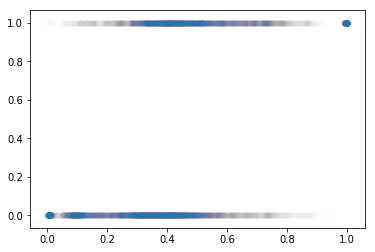

In [48]:
fig, ax = plt.subplots()
ax.scatter(y_pred_b, y_test, alpha=0.003)

In [49]:
roc_auc_b = roc_auc_score(y_test, y_pred_b)
fpr_b, tpr_b, thresholds_b = roc_curve(y_test, y_pred_b)

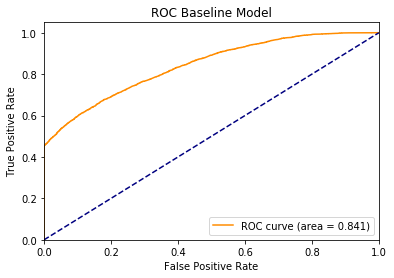

In [50]:
fig, ax = plt.subplots()
plt.plot(fpr_b, tpr_b, color='darkorange', label= f'ROC curve (area = {round(roc_auc_b, 3)})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Baseline Model')
plt.legend(loc="lower right")
plt.show()

In [51]:
features_importances = pd.DataFrame(baseline_model.feature_importances_, index=X_train.columns)
features_importances_sorted = features_importances.sort_values(by=0, ascending=False)

In [52]:
features_importances_sorted

,0
bill_num,0.339856
num_sponsors,0.195006
rep_score,0.146201
minority_score,0.137473
House Bills,0.037750
Senate Bills,0.031721
Session Laws,0.023310
Senate Passed Legislature,0.020740
House Passed Legislature,0.018914
House Resolutions,0.012096


In [53]:
len(X_train.columns)

18